0.0014414269965019085 1.9186940150287122
0.00036557015618504245 1.9792775670111245
9.172308774869003e-05 1.994791471376965


/Users/wilhelmfaerden/miniforge3/envs/fenicsx-env/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


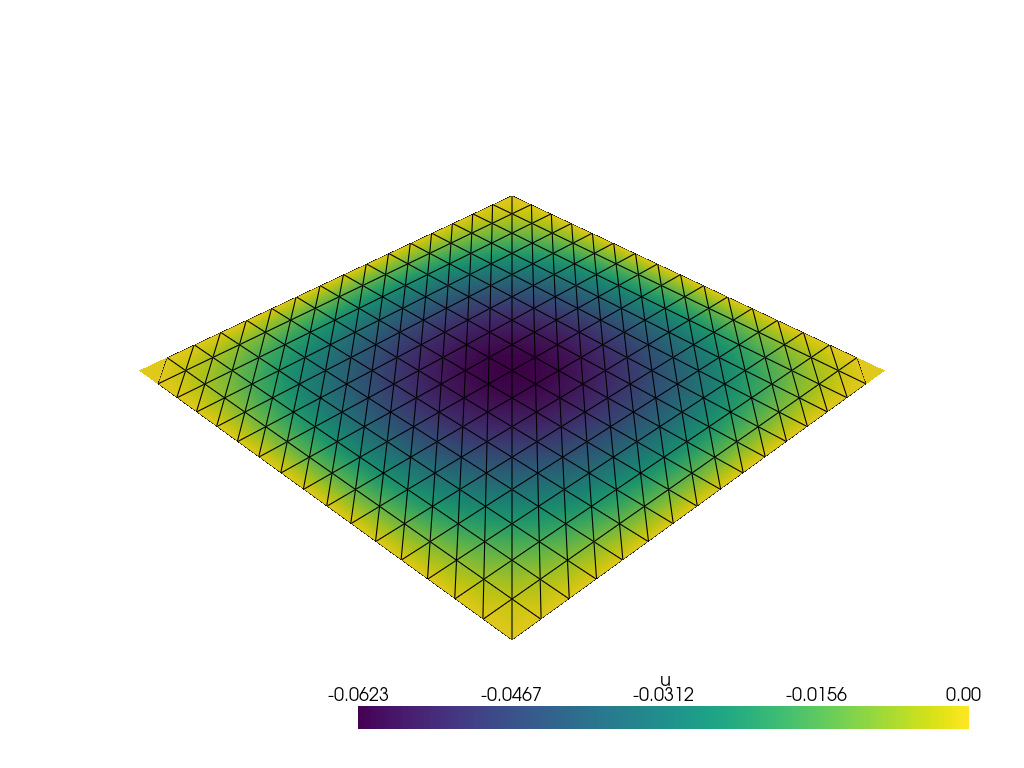

In [4]:
from mpi4py import MPI
from dolfinx import mesh, fem, plot
import numpy as np
from petsc4py.PETSc import ScalarType
import ufl
from dolfinx.fem.petsc import LinearProblem
import matplotlib.pyplot as plt
import pyvista


def solve_poisson(nx=16):
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((0.0,0.0),(1.0,1.0)),
        n=(nx,nx),
        cell_type=mesh.CellType.triangle
    )

    V = fem.functionspace(msh,("Lagrange",1))


    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    def marker(x):
        return (
            np.isclose(x[0],0.0)
            | np.isclose(x[1],0.0)
            | np.isclose(x[0],1.0)
            | np.isclose(x[1],1.0)
        )

    facets = mesh.locate_entities_boundary(msh,dim=(msh.topology.dim-1), marker=marker)
    dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
    bc = fem.dirichletbc(value=ScalarType(0),dofs=dofs,V=V)

    # RHS

    x = ufl.SpatialCoordinate(msh)
    f = -2*(x[0]*(1-x[0]) + x[1]*(1-x[1]))

    a = ufl.inner(ufl.grad(u),ufl.grad(v))*ufl.dx
    L = ufl.inner(f,v)*ufl.dx

    # Problem
    problem = LinearProblem(
        a,
        L,
        bcs=[bc],
        petsc_options_prefix="test_poisson_",
        petsc_options={
            "ksp_type":"preonly",
            "pc_type":"lu",
            "ksp_error_if_not_converged":True
            }
    )

    uh = problem.solve()

    u_exact = -x[0]*x[1]*(1-x[0])*(1-x[1])
    l2_error = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(uh-u_exact,uh-u_exact)*ufl.dx)))
    return uh, l2_error, msh, V




# order analysis

for i in range(4):
    err= solve_poisson(2**(i+2))[1]
    if i > 0:
        rate = np.log(preerr/err)/np.log(2)
        print(err,rate)
    preerr = err
    

uh, l2error, msh, V = solve_poisson()


"""
# Plotting with matplotlib
coords = msh.geometry.x[:,:2]
u_array = uh.x.array
triangles = msh.topology.connectivity(2,0).array.reshape(-1,3)

fig,ax = plt.subplots()
contour = ax.tricontour(
    coords[:,0], coords[:,1], triangles, u_array, levels=20, cmap="viridis"
)

ax.triplot(coords[:,0], coords[:,1], triangles, "k-", lw=0.5, alpha=0.5)
ax.set_title("2D DOLFINx Function with Matplotlib")
fig.colorbar(contour,ax=ax)
plt.tight_layout()
plt.show()
"""

# pyvista plotting
cells, types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(cells,types,x)
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter()
plotter.add_mesh(grid,show_edges=True)
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
plotter.show()



